In [16]:
import os
import glob
import pandas as pd
import matplotlib as mpl

mpl.rcParams.update({
    'font.size': 16,         # 全局字体大小
    'axes.titlesize': 16,      # 坐标轴标题大小
    'axes.labelsize': 14,      # 坐标轴标签大小
    'xtick.labelsize': 14,     # x轴刻度字体大小
    'ytick.labelsize': 14,     # y轴刻度字体大小
    'legend.fontsize': 14,     # 图例字体大小
    'figure.titlesize': 18,    # 整体图标题大小
})

os.chdir('/mnt/d/code/ChimeraBenchmark')

dir_pattern = "benchmark_results_*_0.7threshold"
all_dirs = sorted(glob.glob(dir_pattern))

all_csv_files = []
for d in all_dirs:
    csv_pattern = os.path.join(d, "*abundance.csv")
    csv_files = glob.glob(csv_pattern)
    all_csv_files.extend(csv_files)


In [17]:
print("共找到的 CSV 文件数：", len(all_csv_files))

共找到的 CSV 文件数： 7416


In [18]:
df_list = []
for csv_file in all_csv_files:
    temp_df = pd.read_csv(csv_file)
    folder_name = os.path.basename(os.path.dirname(csv_file))
    core_name = folder_name.replace("benchmark_results_", "").replace("_0.7threshold", "")
    if "completeONE" in core_name:
        db_type = "completeONE"
        data_type = core_name.replace("_completeONE", "")
    else:
        db_type = "complete"
        data_type = core_name.replace("_complete", "")
    temp_df["DataType_Folder"] = data_type
    temp_df["DBType_Folder"] = db_type
    
    df_list.append(temp_df)
df_all = pd.concat(df_list, ignore_index=True)

print("合并后的 DataFrame 形状:", df_all.shape)
df_all.head()

合并后的 DataFrame 形状: (51912, 7)


,Dataset Name,Database,Taxonomic Rank,Software,L1 Distance,DataType_Folder,DBType_Folder
0,sample0_anonymous_gsa,completeONE,Superkingdom,bracken,0.0349,marlong,completeONE
1,sample0_anonymous_gsa,completeONE,Phylum,bracken,0.1272,marlong,completeONE
2,sample0_anonymous_gsa,completeONE,Class,bracken,0.2001,marlong,completeONE
3,sample0_anonymous_gsa,completeONE,Order,bracken,0.3182,marlong,completeONE
4,sample0_anonymous_gsa,completeONE,Family,bracken,0.4263,marlong,completeONE


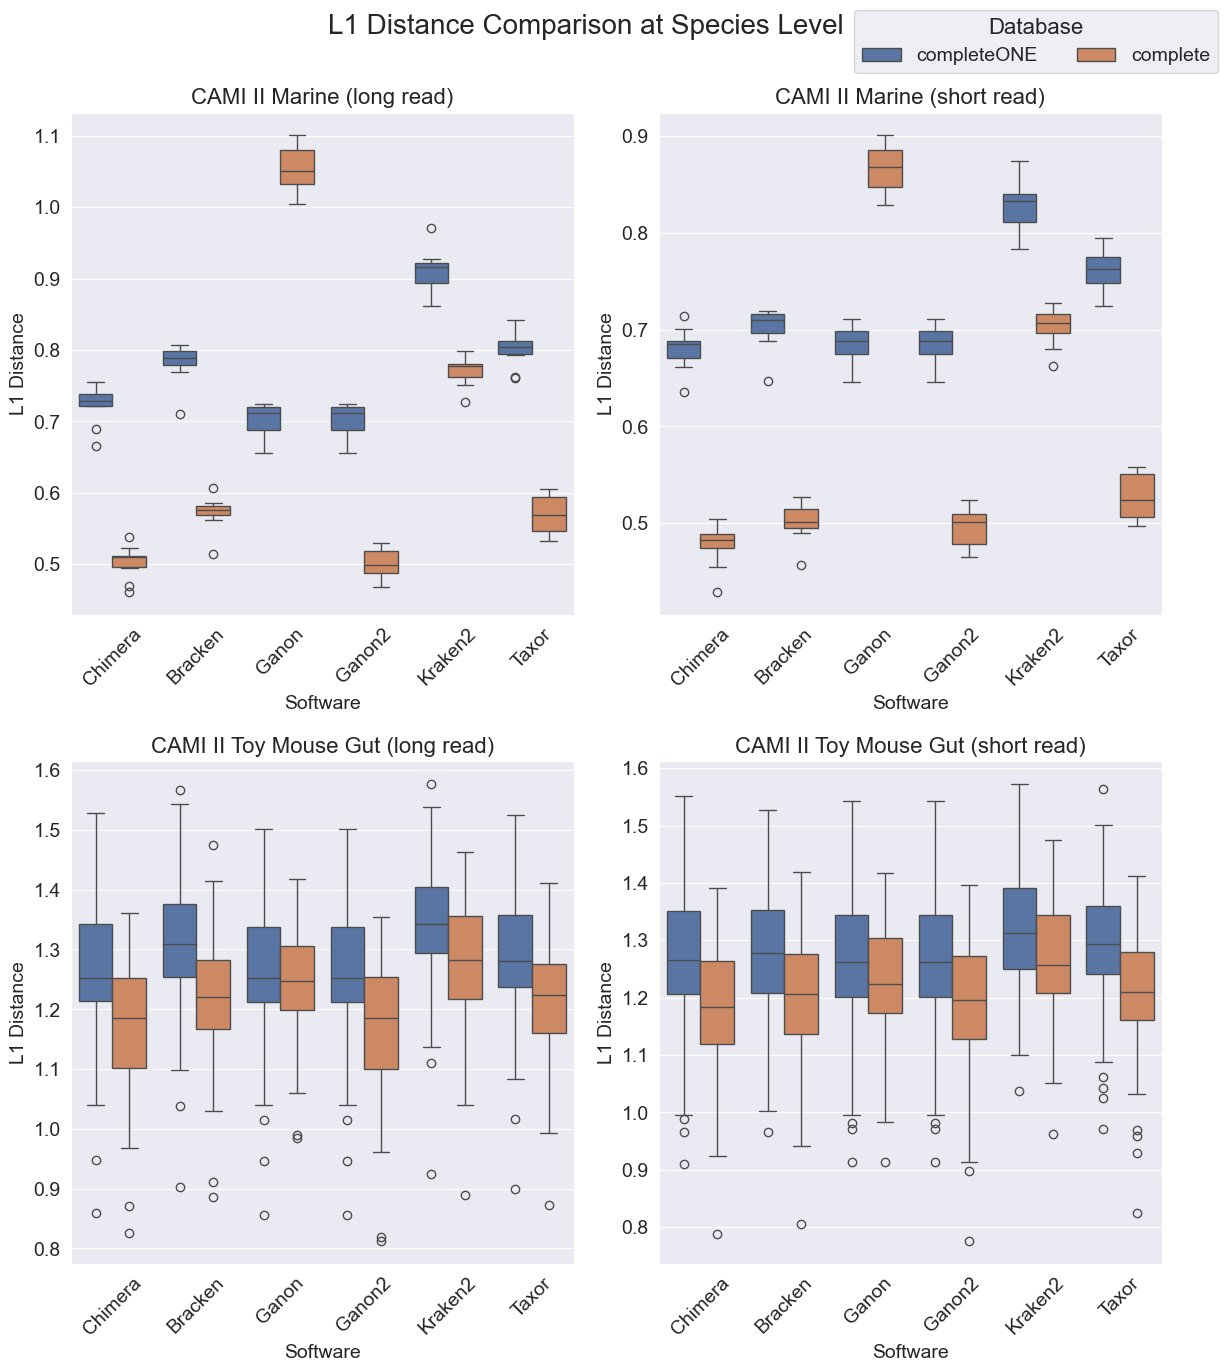

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===== 1. 预处理：只保留 Species 级别 & 排除 simulated ==================
df_species = df_all[
    (df_all["Taxonomic Rank"] == "Species") &
    (df_all["DataType_Folder"] != "simulated")
].copy()

# ===== 2. 映射 DataType_Folder 到更易读的名称 ==========================
data_type_labels = {
    "marlong": "CAMI II Marine (long read)",
    "marshort": "CAMI II Marine (short read)",
    "mouselong": "CAMI II Toy Mouse Gut (long read)",
    "mouseshort": "CAMI II Toy Mouse Gut (short read)"
}

df_species["DataType_Folder_Nice"] = df_species["DataType_Folder"].map(data_type_labels)

df_species = df_species.dropna(subset=["DataType_Folder_Nice"])

unique_data_types = sorted(df_species["DataType_Folder_Nice"].unique())

# ===== 3. 软件名称首字母大写 & Chimera 放在最左 ========================
# 先把所有 software 名字的首字母大写
df_species["Software"] = df_species["Software"].str.capitalize()

# 获取所有软件名，排好序后把 "Chimera" 手动放最前
software_order = sorted(df_species["Software"].unique())
if "Chimera" in software_order:
    software_order.remove("Chimera")
    software_order = ["Chimera"] + software_order

# ===== 4. 子图布局：2行×2列，分别画4个数据集 ===========================
fig, axes = plt.subplots(2, 2, figsize=(12, 14), sharey=False)
axes = axes.flatten()  # 把二维数组展平，方便用 axes[i] 索引
# sns.set_style("whitegrid")
# sns.set_context("talk")
sns.set_palette("deep")
for i, dt_nice in enumerate(unique_data_types):
    ax = axes[i]
    
    # 筛选当前 data_type 对应的数据
    sub_df = df_species[df_species["DataType_Folder_Nice"] == dt_nice]
    
    if sub_df.empty:
        ax.set_title(f"{dt_nice}\n(无数据)")
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    
    # 在同一个子图里，用 hue 区分 complete / completeONE
    # 并指定软件的绘制顺序 order=software_order
    sns.boxplot(
        data=sub_df,
        x="Software",
        y="L1 Distance",
        hue="DBType_Folder",
        order=software_order,
        ax=ax
    )
    
    # 设置子图标题
    ax.set_title(dt_nice)
    
    # 旋转 x 轴标签，防止重叠
    ax.tick_params(axis="x", rotation=45)
    
    # 为了让图例不在每个子图都重复，先临时移除
    if ax.get_legend():
        ax.legend_.remove()

# ===== 5. 设置大标题，并将图例放在大标题下方 ============================
plt.suptitle("L1 Distance Comparison at Species Level", fontsize=20)  # 大标题，可自行修改

# 调整顶部边距，给大标题和图例留空间
plt.tight_layout(rect=[0, 0, 1, 0.98])  # 调整子图整体布局，顶部预留空间给标题

# 从最后一个子图（或第一个非空子图）获取句柄和标签，统一放在 figure 级别
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(
    handles, 
    labels, 
    loc="upper center",          # 位于整张图的上方居中
    bbox_to_anchor=(0.875, 0.99), 
    ncol=2,                      # 两列排列
    title="Database"             # 把图例标题从 DBType_Folder 改成 "Database"
)

# axes[0].text(
#     x=-0.05, y=1,          # 相对坐标，可根据需要微调
#     s="A",                   # 显示字母 A
#     transform=axes[0].transAxes,  # 使用子图自身的坐标系
#     fontsize=14, fontweight="bold",
#     ha="right", va="bottom"  # 对齐方式
# )
# 
# axes[1].text(
#     x=-0.05, y=1, 
#     s="B",
#     transform=axes[1].transAxes,
#     fontsize=14, fontweight="bold",
#     ha="right", va="bottom"
# )
# 
# axes[2].text(
#     x=-0.05, y=1, 
#     s="C",
#     transform=axes[2].transAxes,
#     fontsize=14, fontweight="bold",
#     ha="right", va="bottom"
# )
# 
# axes[3].text(
#     x=-0.05, y=1, 
#     s="D",
#     transform=axes[3].transAxes,
#     fontsize=14, fontweight="bold",
#     ha="right", va="bottom"
# )

plt.show()


In [26]:
# 保存图片为SVG和PDF格式
fig.savefig("L1_Distance_Comparison_Species_Level.svg", format="svg", bbox_inches="tight")
fig.savefig("L1_Distance_Comparison_Species_Level.pdf", format="pdf", bbox_inches="tight")